In [1]:
import torchvision 
import numpy as np
import torch
import torch.autograd as autograd
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
import torch.nn as nn
import pylab as pl
import time
import math
import pickle
from IPython import display
import torch.nn.functional as F
from copy import deepcopy
import cifarResnet
from torchsummary import summary
from matplotlib import pyplot as plt
from scipy.misc import bytescale

torch.cuda.set_device(3) # Set gpu number here

In [2]:
train_set = torchvision.datasets.CIFAR100(root='/data/xay2/cifar100', train=True, download=True)
test_set = torchvision.datasets.CIFAR100(root='/data/xay2/cifar100', train=False, download=True)
with open('/data/xay2/cifar100/cifar-100-python/train', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
    train_data = d[b'data'].reshape(-1,3,32,32)
    train_labels = np.array(d[b'fine_labels'])
with open('/data/xay2/cifar100/cifar-100-python/test', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
    testdata = d[b'data'].reshape(-1,3,32,32)
    testlabels = np.array(d[b'fine_labels'])
    
train_size = 40000
val_size = 10000
traindata = train_data[:train_size]
trainlabels = train_labels[:train_size]
valdata = train_data[train_size:train_size+val_size]
vallabels = train_labels[train_size:train_size + val_size]

traindata = torch.Tensor(traindata.astype(np.float64))
trainlabels = torch.Tensor(trainlabels.astype(np.float64)).long()
valdata = torch.Tensor(valdata.astype(np.float64))
vallabels = torch.Tensor(vallabels.astype(np.float64)).long()
testdata = torch.Tensor(testdata.astype(np.float64))
testlabels = torch.Tensor(testlabels.astype(np.float64)).long()


standardize = torchvision.transforms.Normalize(mean=[125.3, 123, 113.9],std=[63, 62.1, 66.7])
traindata = torch.cat([standardize(traindata[i]).view(1,3,32,32) for i in range(len(traindata))],dim=0).float()
valdata = torch.cat([standardize(valdata[i]).view(1,3,32,32) for i in range(len(valdata))],dim=0).float()
testdata = torch.cat([standardize(testdata[i]).view(1,3,32,32) for i in range(len(testdata))],dim=0).float()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Define our helper functions

def alter(t):
    # flip and crop
    if np.random.random(1) > .5:
        inv_idx = torch.arange(t.size(2)-1,-1,-1).long()
        result = t[:,:,inv_idx]
    else:
        result = t
    result = F.pad(result.view(1,3,32,32),(4,4,4,4)).data
    x = np.random.randint(0,high=9)
    y = np.random.randint(0,high=9)
    return result[0,:,x:x+32,y:y+32].contiguous()

def batchmaker(theset, thelabels, shot=100, alterful=False):
    batch = np.random.choice(len(theset),shot,replace=False)
    data = (torch.cat([alter(theset[i]).view(1,3,32,32) for i in batch],dim=0).float()
            if alterful else
            torch.cat([theset[i].view(1,3,32,32) for i in batch],dim=0).float())
    labels = torch.LongTensor(np.array([thelabels[i] for i in batch]))
    
    return(Variable(data).cuda(),
           Variable(labels).cuda()
          )

criterion = nn.CrossEntropyLoss().cuda()

def evaluate(model, criterion, testing_data, testing_labels, shot=1000):
    support, targs = batchmaker(testing_data, testing_labels, shot=shot)
    c = 200
    assert shot%c==0
    batches = int(shot//c)
    support = support.view(batches, c, 3, 32, 32)
    targs = targs.view(batches, c)
    acc = 0
    loss = 0
    with torch.no_grad():
        for i in range(batches):
            preds = model(support[i,:,:,:,:])
            loss += criterion(preds, targs[i,:]).data[0]
            _,bins = torch.max(preds, 1)
            acc += torch.sum(torch.eq(bins,targs[i,:])).data[0]
    acc = float(acc)/shot
    loss = float(loss)/batches
    return loss, acc

In [4]:
model = cifarResnet.ResNet(9,16).cuda()
i = model.fc.in_features
model.fc = nn.Linear(i,100).cuda()
#model after fine tuning
checkpoint = torch.load('/data/xay2/scripts/pretrained_resnet/fine_tune.pth')
model.load_state_dict(checkpoint)

for param in model.parameters():
    assert param.requires_grad is True


In [5]:
def train(data, targets, model):
    # Train!

    %matplotlib inline

    vbity = 500
    epoch = 800
    limit = 3200
    ensemble = list(range(1)) # Set the number of models that you want to train here
    allscores = []
    alltrainloss = []
    alltestloss = []
    start = time.time()
    for b in ensemble:
        #model = cifarResnet.ResNet(9,16).cuda()
        optimizer = torch.optim.SGD(model.parameters(),lr=.1,weight_decay=.0001,momentum=.9)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: min(1/(10**(x)),.1))
        losstracker = []
        evalacctracker = []
        evallosstracker = []
        runningloss = 0
        for it in range(limit):
            if it%50==0:
                print(it)

            # Build batch
            support, targs = batchmaker(data, targets, int(targets.size()[0]/3),alterful=True)
            model.train()
            # Predict
            model.zero_grad()
            preds = model(support)

            # Calculate Loss
            loss = criterion(preds, targs)
            runningloss += loss.item()

            # Backprop
            if it%epoch == 0:
                scheduler.step()
            loss.backward()
        #     nn.utils.clip_grad_norm(model.parameters(), 1)
            optimizer.step()

            # Report
            if it%vbity == vbity-1:
                display.clear_output(wait=True)
                print("size of train_labels", targets.size()[0])
                print("Approximately %.2f hours to completion"%(
                    (time.time()-start)/(it+1+b*limit)*((len(ensemble)-b)*limit-it)/3600))

                losstracker.append(runningloss/vbity)
                model = model.eval()
                evalloss, evalacc = evaluate(model, criterion, valdata, vallabels, shot=10000)
                model = model.train()
                evallosstracker.append(evalloss)
                evalacctracker.append(evalacc)

                pl.figure(1,figsize=(15,5))
                pl.subplot(1,2,1)
                pl.plot(losstracker)
                pl.plot(evallosstracker)
                pl.ylim((0,1))
        #         pl.xlim((0,limit*epoch))
                pl.title("Loss: Training Blue, Validation Gold")
                pl.subplot(1,2,2)
                pl.plot(evalacctracker[::-1])
                pl.ylim((0,.2))
        #         pl.xlim((0,limit*epoch))
                pl.title("Validation Acc")
                pl.show()

                print("Train loss is: "+str(runningloss/vbity)+
                      "\nValidation accuracy is: "+str(evalacc)+
                      "\nValidation loss is: "+str(evalloss)+"\n")
                runningloss = 0
                #print(allscores)
        model.eval()
        _,score = evaluate(model, criterion, valdata, vallabels, shot=10000)
        allscores.append(score)
        alltrainloss.append(losstracker)
        alltestloss.append(evallosstracker)

    print("Average score is", np.mean(allscores))

In [6]:
#kl divergence 
def kld(p,q):
    return torch.sum(p * torch.log(p / q) ,dim=1)

In [7]:
def query(traindata, trainlabels,shot=800, n_committee=3):    
    batch_data, batch_targets = batchmaker(traindata, trainlabels, shot, False)
    ensemble = list(range(n_committee))
    softmax = nn.Softmax(dim=1)
    preds_ensemble = []
    for _ in ensemble:
        preds = model(batch_data, True)
        prob = softmax(preds)
        preds_ensemble.append(prob)

    preds_ensemble = torch.stack(preds_ensemble)
    consensus = (torch.sum(preds_ensemble,dim=0)/len(ensemble))

    loss=[]
    for b in ensemble:
        loss.append(kld(preds_ensemble[b], consensus))
    loss = torch.stack(loss).sum(dim=0) / len(ensemble)
    #threshold = (torch.max(loss)+torch.min(loss))*0.5
    #print("Threshold: ",threshold)
    batch_train_targets = batch_targets[torch.topk(loss, 384)[1]]
    batch_train_data = batch_data[torch.topk(loss, 384)[1]]
    #batch_train_targets = batch_targets[loss>threshold]
    #batch_train_data = batch_data[loss>threshold]
    #print(batch_train_targets.size())
    return batch_train_data, batch_train_targets

In [8]:
#batch_train_data, batch_train_targets = query(traindata, trainlabels)
#print(batch_train_data.size())

size of train_labels 384
Approximately 0.00 hours to completion


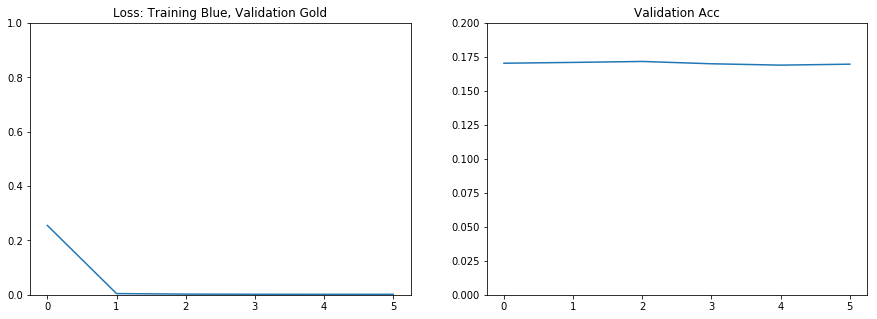

Train loss is: 0.0018385780900716782
Validation accuracy is: 0.1704
Validation loss is: 6.315010375976563

3000
3050
3100
3150
Average score is 0.1705


In [9]:
train_count =[]
for _ in range(15):
    batch_train_data, batch_train_targets = query(traindata, trainlabels)
    print(batch_train_data.size())
    train_count.append(batch_train_targets.size()[0])
    train(batch_train_data,batch_train_targets,model)
    

In [10]:
print(train_count)

[384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384]
